In [1]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
import PIL
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

import preprocessing.VideoFrameDataset as VFD
import model.Encoder as E
import model.Loss as L

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
root = 'data/camera_1_videos'
BATCH_SIZE = 1 #One batch corresponds to one video with first 700 frames extracted.
QUEUE_SIZE = 28
EPOCHS = 10
LEARNING_RATE_ATTRACTION = 0.01
LEARNING_RATE_REPULSION = 0.05

In [3]:
dataset = VFD.VideoFrameDataset(root)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

In [4]:
model = E.BasicEncoder()
model = model.to(device)
attraction_loss = L.PairwiseEuclideanLoss()
attraction_optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_ATTRACTION)
repulsion_loss = L.NegativePairwiseEuclideanLossLoss()
repulsion_opimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_REPULSION)

In [5]:
average_attractive_loss_list = []
average_repulsive_loss_list = []
for epoch in range(EPOCHS):

    print("Starting Epoch ", epoch, "...")

    average_repulsive_loss = np.ndarray([])
    batch_num = 0
    for batch in dataloader:

        print("Starting Batch ", batch_num, ":")

        average_attractive_loss = np.ndarray([])
        video = batch[0]
        queue_index = 0
        average_temporal_embeddings = torch.Tensor().to(device)
        while(queue_index + QUEUE_SIZE <= len(video)):
            temporal_queue = video[queue_index : queue_index + QUEUE_SIZE]
            temporal_queue = temporal_queue.to(device)
            outputs = model(temporal_queue)
            loss_att = attraction_loss(outputs)
            attraction_optimizer.zero_grad()
            loss_att.backward()
            attraction_optimizer.step()
            average_output = torch.mean(outputs, dim = 0)
            average_output = average_output.unsqueeze(0)
            average_temporal_embeddings = torch.cat((average_temporal_embeddings, average_output), dim = 0)
            average_attractive_loss = np.append(average_attractive_loss, loss_att.detach().cpu().numpy())
            queue_index+=1

            if(queue_index%50 == 0):
                print("Processing Queue: ", queue_index, "| Attraction Loss = ", loss_att)

        repulsion_opimizer.zero_grad()
        loss_rep = repulsion_loss(average_temporal_embeddings)
        repulsion_opimizer.step()
        average_repulsive_loss = np.append(average_repulsive_loss, loss_rep.detach().cpu().numpy())
        batch_num+=1

        print("Finished processing batch: ", batch_num, "| Repulsion Loss = ", loss_rep)
        print()
    
    average_attractive_loss_list.append(np.mean(average_attractive_loss))
    average_repulsive_loss_list.append(np.mean(average_repulsive_loss))

    print("Finished processing epoch: ", epoch, "| Average Repulsion Loss = ", np.mean(average_repulsive_loss), "| Average Attraction Loss = ", np.mean(average_attractive_loss))
    print()
        

Starting Epoch  0 ...
Starting Batch  0 :
Processing Queue:  50 | Attraction Loss =  tensor(0.0687, device='cuda:0', grad_fn=<MeanBackward0>)
Processing Queue:  100 | Attraction Loss =  tensor(0.0483, device='cuda:0', grad_fn=<MeanBackward0>)
Processing Queue:  150 | Attraction Loss =  tensor(0.0529, device='cuda:0', grad_fn=<MeanBackward0>)
Processing Queue:  200 | Attraction Loss =  tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>)
Processing Queue:  250 | Attraction Loss =  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
Processing Queue:  300 | Attraction Loss =  tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
Processing Queue:  350 | Attraction Loss =  tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>)
Processing Queue:  400 | Attraction Loss =  tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>)
Processing Queue:  450 | Attraction Loss =  tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward0>)
Processing Queue:  500 | Attraction Loss =  tensor

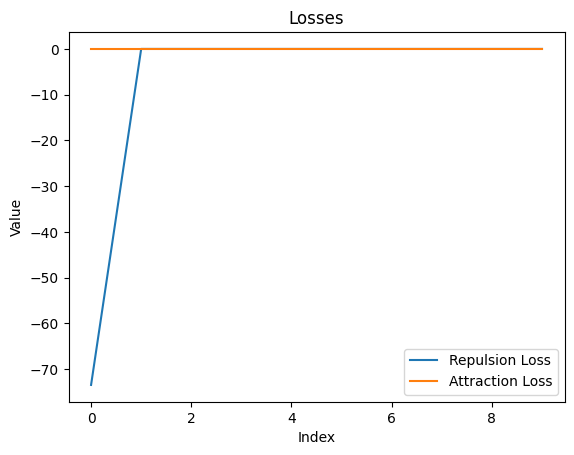

In [6]:
plt.plot(range(len(average_repulsive_loss_list)), average_repulsive_loss_list, label="Repulsion Loss")
plt.plot(range(len(average_attractive_loss_list)), average_attractive_loss_list, label="Attraction Loss")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Losses")
plt.legend()
plt.show()